In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Analyzing experiments without atoms

In [3]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids=['2018_03_20_10_18_31_Open loop camera data purpose, IQ1=0, IQ2=0',
         '2018_03_20_10_58_52_Open loop camera data purpose, IQ1=0, IQ2=0',
         '2018_03_20_11_47_30_Open loop camera data purpose, IQ1=1.24, IQ2=1.5'
        ]

data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_10_18_31_Open loop camera data purpose, IQ1=0, IQ2=0/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_10_58_52_Open loop camera data purpose, IQ1=0, IQ2=0/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_11_47_30_Open loop camera data purpose, IQ1=1.24, IQ2=1.5/qdp.txt


<IPython.core.display.Javascript object>


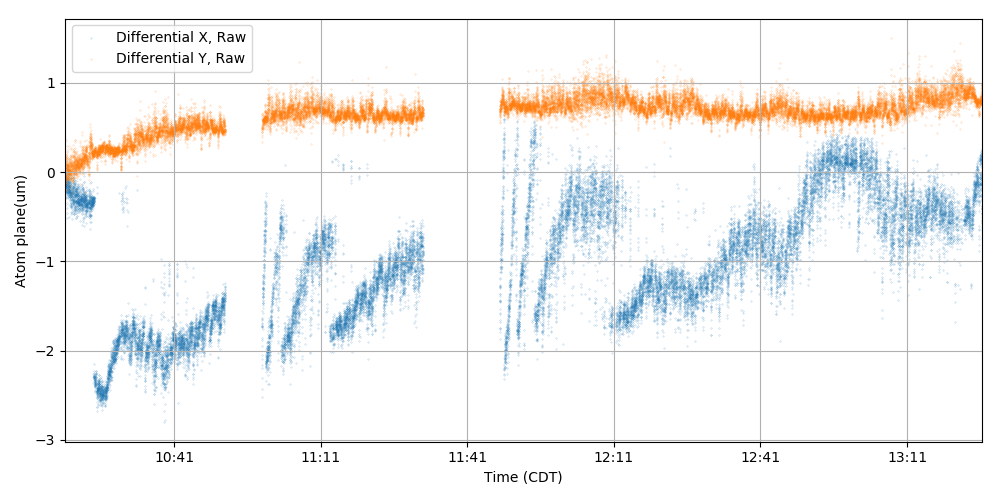

In [5]:
# Raw plotting
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.05,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.05,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
#ax.set_ylim(-2,2)
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop.png')

In [6]:
# Using Pandas
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0-flatteneddata0[0],
                 'Red Y': flatteneddata1-flatteneddata1[0],
                 'FORT X': flatteneddata2-flatteneddata2[0],
                 'FORT Y': flatteneddata3-flatteneddata3[0]
                },index=dates)

<IPython.core.display.Javascript object>


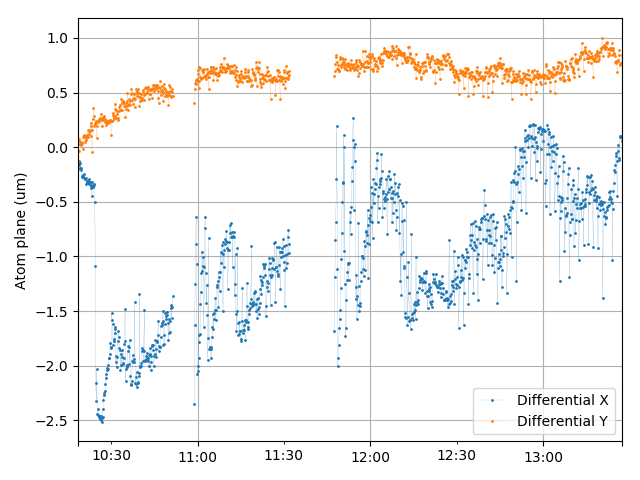

<IPython.core.display.Javascript object>


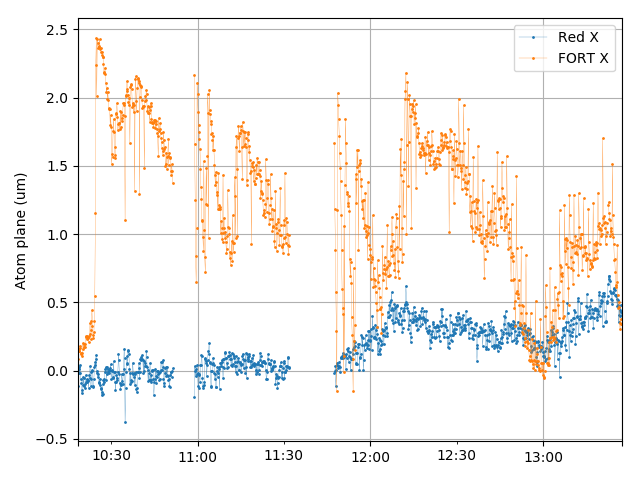

<IPython.core.display.Javascript object>


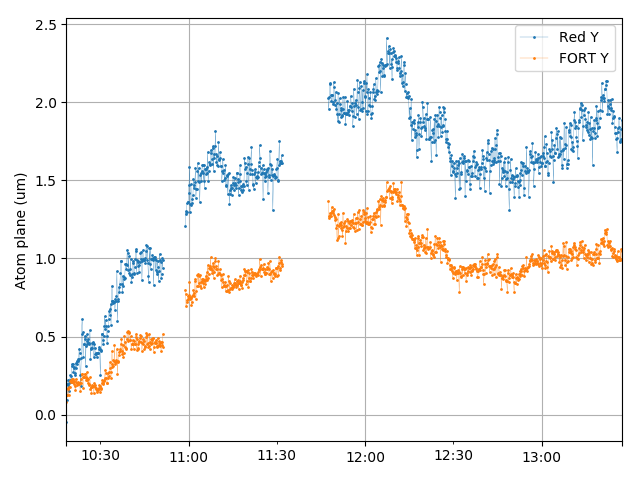

In [25]:
savefig=True
samplerate='10S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.1,marker='.',markersize=2)
ax.axvspan('10:00','11:45')
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('CoilDutyCycle_differential.png',dpi=600)
#ax.set_ylim(-1,1)

#samplerate='1S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Red X','FORT X'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('CoilDutyCycle_AbsX.png',dpi=600)
#ax.set_ylim(-5,2)

#samplerate='1S'
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Red Y','FORT Y'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('CoilDutyCycle_AbsY.png',dpi=600)

#ax.set_ylim(-1.5,1)

In [23]:
# Using Pandas, in camera plane
mag_Red=20.8
mag_FORT=23.8
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps]

flatteneddata0=np.array(flatten(data[keylist[0]]))
flatteneddata2=np.array(flatten(data[keylist[2]]))
flatteneddata1=np.array(flatten(data[keylist[1]]))
flatteneddata3=np.array(flatten(data[keylist[3]]))

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df2=pd.DataFrame({'Red X@camera': mag_Red*(flatteneddata0-flatteneddata0[0]),
                 'Red Y@camera': mag_Red*(flatteneddata1-flatteneddata1[0]),
                 'FORT X@camera': mag_FORT*(flatteneddata2-flatteneddata2[0]),
                 'FORT Y@camera': mag_FORT*(flatteneddata3-flatteneddata3[0])
                },index=dates)

<IPython.core.display.Javascript object>


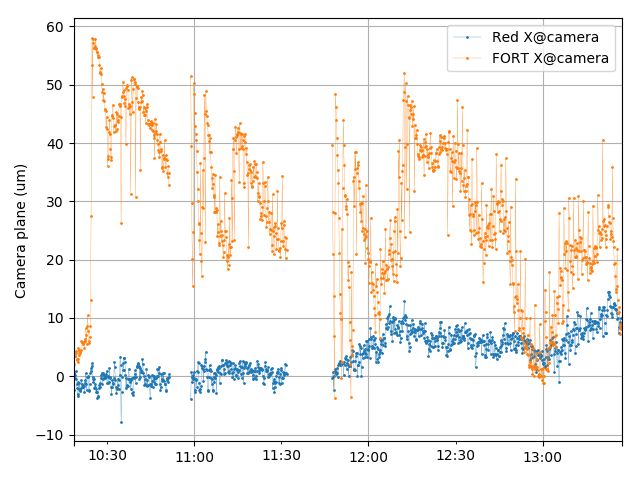

<IPython.core.display.Javascript object>


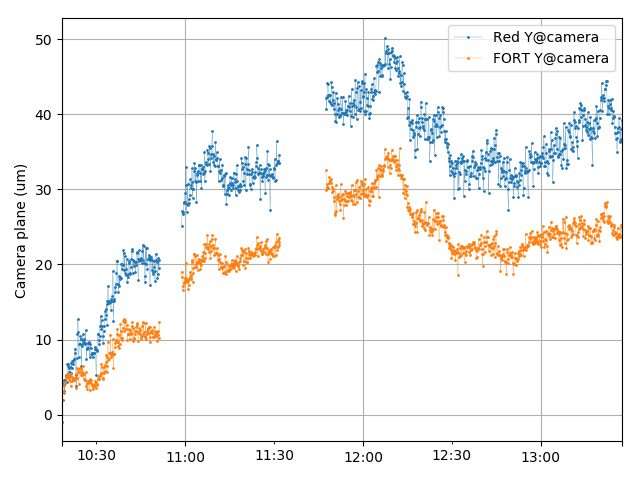

In [24]:
savefig=True
samplerate='10S'

data_to_plot2=df2.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Red X@camera','FORT X@camera'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Camera plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop_AbsX.png',dpi=600)
#ax.set_ylim(-5,2)

ax=data_to_plot2.plot(y=['Red Y@camera','FORT Y@camera'],lw=0.2,marker='.',markersize=2)
ax.set_ylabel('Camera plane (um)')
ax.grid()
ax.legend()
plt.tight_layout()
if savefig:
    plt.savefig('ClosedloopAAS_AC_Starkshift_20180314_through_20180316_and_openloop_AbsY.png',dpi=600)